The section below is used for importing all the required dependencies in the project.
1. **BeautifulSoup** is a Python library used for web scraping. It enables developers to extract specific data from HTML and XML documents by parsing and navigating the document structure. It simplifies the process of web scraping by providing a Pythonic interface to interact with web page content.

2. **The LogisticRegression class in scikit-learn** is a machine learning model used for classification tasks. It predicts a categorical outcome (e.g., “Positive” or “Negative”) based on input data. Despite its name, logistic regression is not a regression algorithm but a probabilistic classification algorithm.

3. **PyTorch**, commonly accessed through the module **torch**, is an open-source machine learning library developed by Facebook. It is widely used for developing deep learning models due to its flexibility, ease of use, and dynamic computational graph capabilities.
PyTorch is built on Python and provides a rich ecosystem for tasks ranging from research to production. It is particularly popular in areas like computer vision, natural language processing (NLP), and reinforcement learning.

4. The **transformers** library, developed by **Hugging Face**, provides state-of-the-art machine learning models for natural language processing (NLP) and beyond. It supports pre-trained models like **BERT**, GPT, RoBERTa, and more, along with tools to fine-tune and use them for tasks such as text classification, **sentiment analysis**, translation, and question answering.

5. **matplotlib.pyplot** is a submodule of the Matplotlib library in Python, which is widely used for creating static, interactive, and animated visualizations. It provides a state-based interface similar to MATLAB, allowing users to create plots and graphs easily.

Device set to use cpu
Device set to use cpu
Device set to use cpu


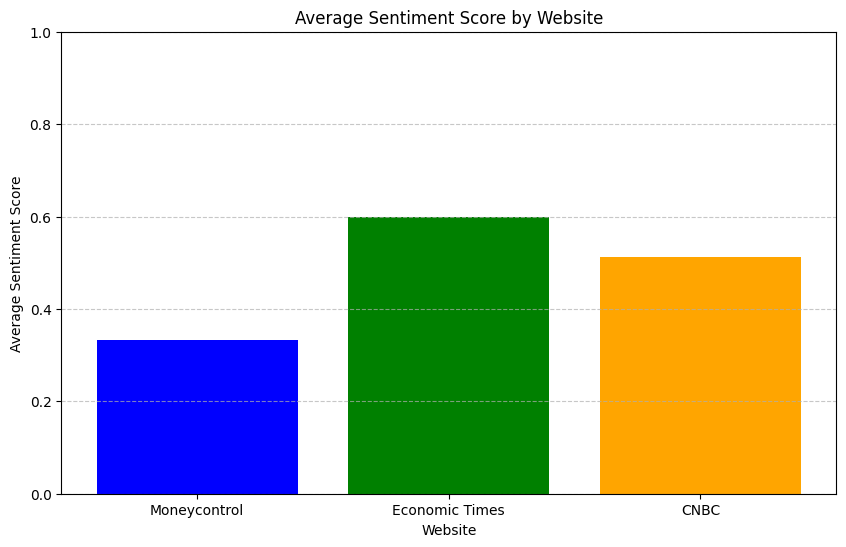

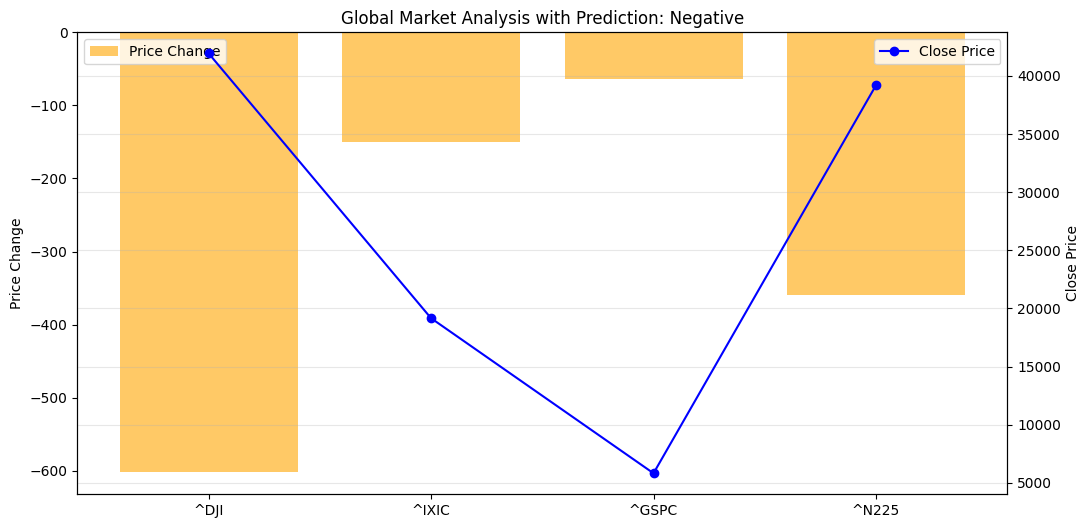

In [11]:
# Importing necessary libraries
import requests  # To make HTTP requests
from bs4 import BeautifulSoup  # For parsing HTML content
import yfinance as yf  # To fetch market data
from sklearn.linear_model import LogisticRegression  # For market trend prediction
import numpy as np  # For numerical computations
import torch  # PyTorch for using transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline  # For sentiment analysis
import pandas as pd  # For data manipulation and saving to CSV
from datetime import datetime  # To handle date and time
import os  # For file operations
import matplotlib.pyplot as plt  # For data visualization

# Function to scrape financial news
def scrape_news(url):
    """
    Scrapes headlines from the given URL based on the structure of the website.
    """
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        headlines = []

        # Parsing headlines based on specific website structure
        # Searches the parsed HTML (stored in the soup object) for all <h2> tags.
	      # Headlines on Moneycontrol are assumed to be enclosed in <h2> tags.
        # Economic Times uses anchor tags with this class to define news headlines. <a>
        if "moneycontrol" in url:
            for article in soup.find_all('h2'):
                headlines.append(article.text.strip())
        elif "economictimes" in url:
            for article in soup.find_all('a', class_='title'):
                headlines.append(article.text.strip())
        elif "cnbc" in url:
            for article in soup.find_all('a', class_='Card-title'):
                headlines.append(article.text.strip())

        if not headlines:
            print(f"No headlines found for {url}. Please check the structure of the web page.")

        return headlines
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return []

# Function to track global market performance
def track_global_markets():
    """
    Fetches the daily close and price change for major global indices.
    """
    indices = ['^DJI', '^IXIC', '^GSPC', '^N225']  # Dow Jones, NASDAQ, S&P 500, Nikkei
    market_data = {}

    for index in indices:
        ticker = yf.Ticker(index)
        hist = ticker.history(period="1d")
        market_data[index] = {
            "Close": hist['Close'].iloc[-1],
            "Change": hist['Close'].iloc[-1] - hist['Open'].iloc[-1]
        }

    return market_data

# Function to perform sentiment analysis on news headlines
def sentiment_analysis(headlines):
    """
    Uses a pretrained model to classify headlines as positive or negative
    and calculates the average sentiment score.
    """
    device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# This is a pre-trained language model from the Hugging Face Transformers library. It is a smaller, faster, and lighter version of
# BERT (Bidirectional Encoder Representations from Transformers) that has been fine-tuned specifically for sentiment analysis on the
# Stanford Sentiment Treebank (SST-2) dataset.
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
# Loads the tokenizer for the model, which converts raw text into numerical tokens that the model can understand.
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
# the sentiment analysis being created , model and tokeizer are specified , device indicates if the pipeline witll run on CPU or GPU
    sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=device)
    sentiments = sentiment_pipeline(headlines) # list of headline being processed through the pipeline

    sentiment_scores = [1 if s['label'] == 'POSITIVE' else 0 for s in sentiments]
    avg_sentiment = np.mean(sentiment_scores) if sentiment_scores else 0

    return sentiment_scores, avg_sentiment

# Function to predict market trend
"""
 Parameters:
	•	global_markets: A dictionary containing global market data (e.g., price changes for major indices like Dow Jones, NASDAQ).
	•	avg_sentiment: A float representing the average sentiment score derived from news headlines (e.g., 0 for negative, 1 for positive).
"""
def predict_market_trend(global_markets, avg_sentiment):
    """
    Predicts whether the market trend will be positive or negative based on
    sentiment analysis and global market data.
    """
    model = LogisticRegression() #Creates a logistic regression model using sklearn Logistic regression is a machine learning algorithm used for binary classification (e.g., predicting positive vs. negative market trends).

    # Dummy data for training (we will replace with real data for production use)
    X_train = np.array([[1, 100], [3, -200], [4, 300], [5, 500], [2, -100]])
    y_train = np.array([1, 0, 1, 1, 0])  # 1 - positive trend, 0 - negative trend

    model.fit(X_train, y_train)

    global_change = sum([data['Change'] for data in global_markets.values()])
    prediction_input = np.array([[avg_sentiment, global_change]])

    trend_prediction = model.predict(prediction_input)

    return "Positive" if trend_prediction == 1 else "Negative"

# Function to save data to CSV
def save_to_csv(file_name, data, headers):
    """
    Appends data to a CSV file. Creates the file if it does not exist.
    """
    file_exists = os.path.isfile(file_name)

    df = pd.DataFrame([data], columns=headers)
    if not file_exists:
        df.to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, mode='a', header=False, index=False)

# Function to visualize sentiment scores
def visualize_sentiment(average_sentiments):
    """
    Creates a bar chart for average sentiment scores of different websites.
    """
    websites = list(average_sentiments.keys())
    scores = list(average_sentiments.values())

    plt.figure(figsize=(10, 6))
    plt.bar(websites, scores, color=['blue', 'green', 'orange'])
    plt.title('Average Sentiment Score by Website')
    plt.xlabel('Website')
    plt.ylabel('Average Sentiment Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Function to visualize global market data and prediction
def visualize_global_market(global_markets, prediction):
    """
    Visualizes global market data and shows the predicted market trend.
    """
    indices = list(global_markets.keys())
    changes = [global_markets[idx]['Change'] for idx in indices]
    close_prices = [global_markets[idx]['Close'] for idx in indices]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar chart for price changes
    ax1.bar(indices, changes, color='orange', alpha=0.6, label="Price Change")
    ax1.set_ylabel("Price Change")
    ax1.set_title(f"Global Market Analysis with Prediction: {prediction}")
    ax1.legend(loc="upper left")

    # Line plot for close prices
    ax2 = ax1.twinx()
    ax2.plot(indices, close_prices, color='blue', marker='o', label="Close Price")
    ax2.set_ylabel("Close Price")
    ax2.legend(loc="upper right")

    plt.grid(alpha=0.3)
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Define URLs for scraping
    urls = {
        "Moneycontrol": "https://www.moneycontrol.com/news/business/markets/",
        "Economic Times": "https://economictimes.indiatimes.com/?from=mdr",
        "CNBC": "https://www.cnbc.com/world/?region=world"
    }

    today = datetime.now().strftime('%Y-%m-%d')

    # Scrape and analyze sentiment
    all_headlines = {}
    sentiment_scores = {}
    average_sentiments = {}

    for site, url in urls.items():
        headlines = scrape_news(url)
        all_headlines[site] = headlines
        scores, avg_sentiment = sentiment_analysis(headlines)
        sentiment_scores[site] = scores
        average_sentiments[site] = avg_sentiment

    # Track global markets
    global_markets = track_global_markets()

    # Predict market trend
    overall_avg_sentiment = np.mean(list(average_sentiments.values()))
    sentiment_inference = "Positive" if overall_avg_sentiment >= 0.5 else "Negative"
    trend = predict_market_trend(global_markets, overall_avg_sentiment)

    # Save results to CSV
    news_headers = ['Date', 'Website', 'Headlines', 'Sentiment Scores', 'Average Sentiment', 'Sentiment Inference']
    for site, headlines in all_headlines.items():
        data = {
            'Date': today,
            'Website': site,
            'Headlines': '; '.join(headlines),
            'Sentiment Scores': sentiment_scores[site],
            'Average Sentiment': average_sentiments[site],
            'Sentiment Inference': "Positive" if average_sentiments[site] >= 0.5 else "Negative"
        }
        save_to_csv('NewsAnalysis.csv', data, news_headers)

    market_headers = [
        'Date', 'News Headlines', 'Sentiment Score', 'Sentiment Inference', 'DJI Close', 'DJI Change',
        'NASDAQ Close', 'NASDAQ Change', 'S&P 500 Close', 'S&P 500 Change',
        'Nikkei Close', 'Nikkei Change', 'Market Prediction'
    ]
    market_data = {
        'Date': today,
        'News Headlines': '; '.join([headline for headlines in all_headlines.values() for headline in headlines]),
        'Sentiment Score': overall_avg_sentiment,
        'Sentiment Inference': sentiment_inference,
        'DJI Close': global_markets['^DJI']['Close'],
        'DJI Change': global_markets['^DJI']['Change'],
        'NASDAQ Close': global_markets['^IXIC']['Close'],
        'NASDAQ Change': global_markets['^IXIC']['Change'],
        'S&P 500 Close': global_markets['^GSPC']['Close'],
        'S&P 500 Change': global_markets['^GSPC']['Change'],
        'Nikkei Close': global_markets['^N225']['Close'],
        'Nikkei Change': global_markets['^N225']['Change'],
        'Market Prediction': trend
    }
    save_to_csv('market_analysis0.csv', market_data, market_headers)

    # Visualize results
    visualize_sentiment(average_sentiments)
    visualize_global_market(global_markets, trend)

In [10]:
# prompt: read market_analysis0.csv and print a formatted  output

import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('market_analysis0.csv')
df2= pd.read_csv('NewsAnalysis.csv')
# Print the formatted output
print(df.to_string(index=False))
print('')
print('')
print(df2.to_string(index=False))

      Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              